In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import pickle

import tensorflow as tf

In [2]:
print(tf.version.VERSION)

tf.config.run_functions_eagerly(True)
tf.data.experimental.enable_debug_mode()

2.8.0


In [3]:
gpus = tf.config.list_physical_devices('GPU')

print(gpus)
tf.config.experimental.set_visible_devices(gpus[0], 'GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
with open('../data/var1.pkl', 'rb') as file:
    train_data, test_data, e_params, t_params, ft_params = pickle.load(file)

In [5]:
# операция обратная стандартизации для восстановления результата
def restore_result(e_vals):
    return e_vals * e_params[1] + e_params[0]

# Dataset

In [6]:
def split_time_series(series, input_width, label_width,
                         step, input_columns, label_columns):
    
    window_size = input_width + label_width
    
    res_len = (len(series) - window_size) // step + 1
    
    x = np.zeros((res_len, input_width, len(input_columns)))
    y = np.zeros((res_len, label_width, len(label_columns)))
    
    for i in range(res_len):
        x[i] = series[i * step: i * step + input_width, input_columns]
        y[i] = series[i * step + input_width : 
                      i * step + window_size, label_columns]
        
    return x, y

In [7]:
def create_dataset(train_series, test_series, 
                   input_width, label_width, step,
                   input_columns, label_columns):
    
    x_train, y_train = split_time_series(train_series, 
                                         input_width, label_width,
                                         step, input_columns, label_columns)
    
    total_series = np.concatenate([train_series, test_series])
    total_series = total_series[len(train_series) - (input_width + label_width) + step :]
    
    x_test, y_test = split_time_series(total_series, 
                                         input_width, label_width,
                                         step, input_columns, label_columns)
    
    '''
    x_train = np.expand_dims(x_train, axis=1)
    y_train = np.expand_dims(y_train, axis=1)
    x_test = np.expand_dims(x_test, axis=1)
    y_test = np.expand_dims(y_test, axis=1)
    '''
    
    return x_train, y_train, x_test, y_test

In [8]:
INPUT_WIDTH = 30
LABEL_WIDTH = 1
STEP = 1

INPUT_COLUMNS = [0, 1, 2, 3, 8, 9, 10, 11, 12, 13]
LABEL_COLUMNS = [0, 1]

In [9]:
x_train, y_train, x_test, y_test = create_dataset(train_data.to_numpy(), test_data.to_numpy(), 
                                                     INPUT_WIDTH, LABEL_WIDTH, STEP,
                                                     INPUT_COLUMNS, LABEL_COLUMNS)

print(x_train.shape, y_train.shape, '\n', x_test.shape, y_test.shape)

(1796, 30, 10) (1796, 1, 2) 
 (365, 30, 10) (365, 1, 2)


# Model

In [16]:
tf.keras.utils.set_random_seed(10)

BATCH_SIZE = 1
MAX_EPOCHS = 1000

In [11]:
def build_model():
    
    model = tf.keras.Sequential([
        tf.keras.layers.Flatten(),
        
        tf.keras.layers.Dense(units=64, activation='relu'),
        tf.keras.layers.Dense(units=64, activation='relu'),
        
        tf.keras.layers.Dense(units=LABEL_WIDTH * len(LABEL_COLUMNS), activation='relu'),
        
        tf.keras.layers.Reshape([LABEL_WIDTH, len(LABEL_COLUMNS)])
    ])
    
    model.build(input_shape=(BATCH_SIZE, INPUT_WIDTH, len(INPUT_COLUMNS)))
    
    model.compile(optimizer='adam', loss='mse', )
    
    return model

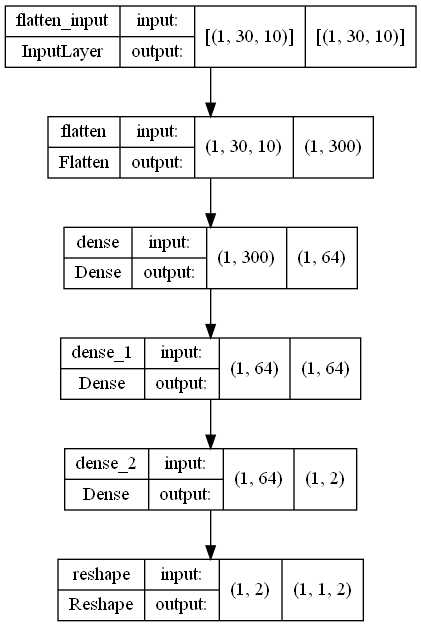

In [12]:
model = build_model()

tf.keras.utils.plot_model(model, show_shapes=True)

In [13]:
log_dir = "./logs"

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)

In [18]:
%reload_ext tensorboard
%tensorboard --logdir {log_dir} --host "0.0.0.0"

Reusing TensorBoard on port 6006 (pid 4240), started 0:04:33 ago. (Use '!kill 4240' to kill it.)

In [17]:
model.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          batch_size=BATCH_SIZE, 
          epochs=MAX_EPOCHS, 
          callbacks=[tensorboard_callback])

Epoch 1/1000
1796/1796 [==============================] - 49s 26ms/step - loss: 0.5568 - val_loss: 0.3629
Epoch 2/1000
1796/1796 [==============================] - 22s 12ms/step - loss: 0.5234 - val_loss: 0.3532
Epoch 3/1000
1796/1796 [==============================] - 23s 13ms/step - loss: 0.5141 - val_loss: 0.3386
Epoch 4/1000
1796/1796 [==============================] - 22s 12ms/step - loss: 0.5087 - val_loss: 0.3479
Epoch 5/1000
1796/1796 [==============================] - 22s 12ms/step - loss: 0.5074 - val_loss: 0.3406
Epoch 6/1000
1796/1796 [==============================] - 22s 12ms/step - loss: 0.5056 - val_loss: 0.3583
Epoch 7/1000
1796/1796 [==============================] - 22s 12ms/step - loss: 0.5021 - val_loss: 0.3350
Epoch 8/1000
1796/1796 [==============================] - 22s 12ms/step - loss: 0.5016 - val_loss: 0.3316
Epoch 9/1000
1796/1796 [==============================] - 23s 13ms/step - loss: 0.4995 - val_loss: 0.3326
Epoch 10/1000
1156/1796 [==================>..

KeyboardInterrupt: 

# Evaluate

In [ ]:
%run evaluate_forecasts.ipynb

evaluate_forecasts(test.to_numpy(), [predicted], ['SNAIVE'])